<p align="center">
  <img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png" alt="image" width="250" />
</p>

<h1 align="center">MultiRat Sensory-Evoked analysis code</h1>

<p align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Marie E Galteau, 2023</i></p>

---

## Second Level Analysis - **Default** Hemodynamic Response Function

The present jupyter notebook contains the code to reproduce the second level analysis. Select the hemodynamic response functions used during the first level analysis: spm or glover. It enables to fetch the files in the corresponding directories. 

Follow the code step-wise. 

In [1]:
# --- Imports ---
import os
import glob
import nilearn 
import numpy as np 
import pandas as pd
import nibabel as nib

from numpy import savetxt
import matplotlib.pyplot as plt
from nilearn import plotting, image, datasets
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

# --- Init variables ---
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'

# --- Data path ---
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

**Select the hemodynamic response function!** 

To input the corresponding data.

In [2]:
# --- Select the HRF ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    spm
    glover
"""
#hrf_function = 'glover'
hrf_function = 'spm'

In [3]:
# --- Output path ---
hrf_function = 'block'
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/second_level/'
subdirectories = ['glover', 'block']

base_dir = os.path.join(output_dir, 'glover') if hrf_function == 'glover' else os.path.join(output_dir, 'block')
image_dir = os.path.join(base_dir, 'image/')
beta_dir = os.path.join(base_dir, 'beta_estimates/')
z_score_dir = os.path.join(base_dir, 'z_score/')
p_value_dir = os.path.join(base_dir, 'p_value/')

for subdir in subdirectories:
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['image', 'beta_estimates', 'z_score', 'p_value']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

### Let's analyse!

1. Load the dataset based on its ID and the HRF function used during first analysis.
2. Compute the design matrix and the first level model
3. Compute the contrast and plot the statistical maps
7. Save ouputs in specific directories

First level analysis used: block
ses 1
ID: 02001
number of subjects: 10
ses 1
ID: 02002
number of subjects: 9
ses 1
ID: 02003
number of subjects: 9
ses 1
ID: 02004
number of subjects: 10
ses 1
ID: 02005
number of subjects: 10
ses 1
ID: 02006
number of subjects: 10
ses 1
ID: 02007
number of subjects: 8
ses 1
ID: 02008
number of subjects: 9
ses 1
ID: 02009
number of subjects: 10
ses 1
ID: 02010
number of subjects: 10
ses 1
ID: 02011
number of subjects: 10
ses 1
ID: 02012
number of subjects: 9
ses 1
ID: 02013
number of subjects: 10
ses 1
ID: 02014
number of subjects: 10
ses 1
ID: 02015
number of subjects: 10
ses 1
ID: 02016
number of subjects: 9
ses 2
ID: 02017
number of subjects: 10
ses 1
ID: 02018
number of subjects: 9
ses 1
ID: 02019
number of subjects: 8
ses 1
ID: 02020
number of subjects: 10
ses 1
ID: 02021
number of subjects: 10


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figure, figsize=figsize, facecolor=facecolor)


ses 1
ID: 02022
number of subjects: 10


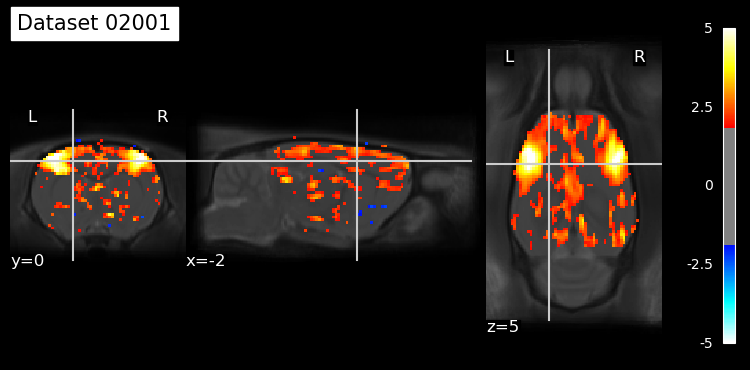

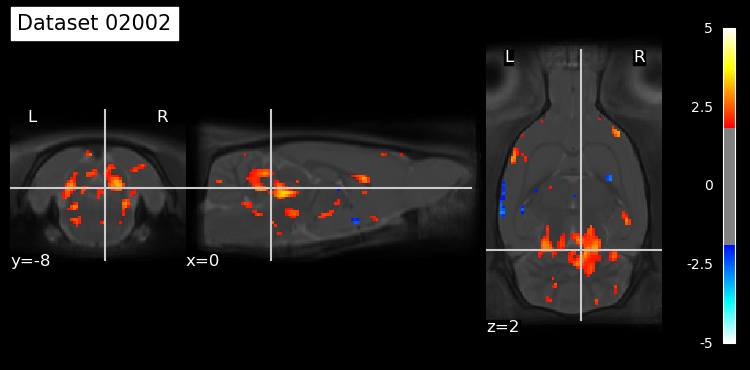

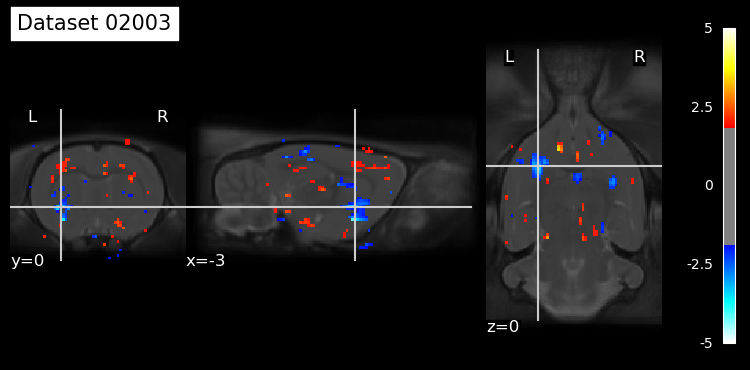

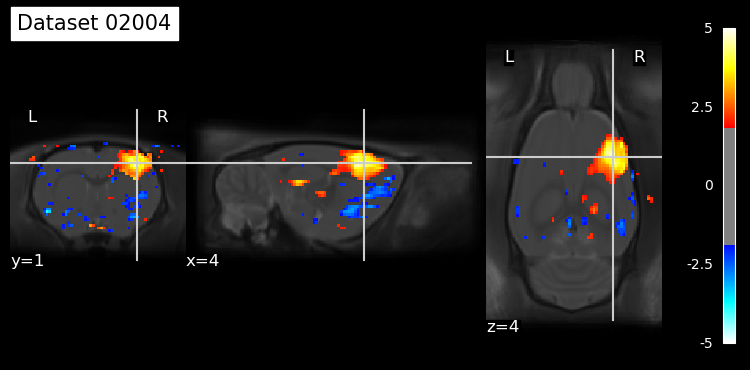

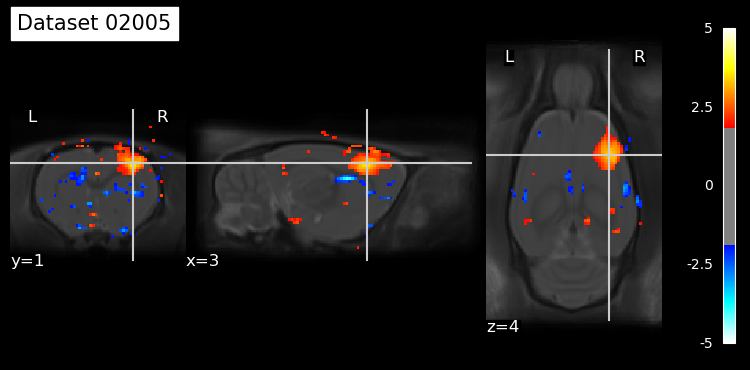

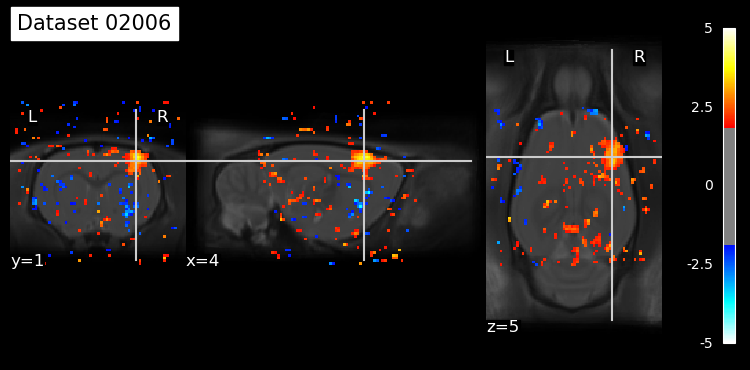

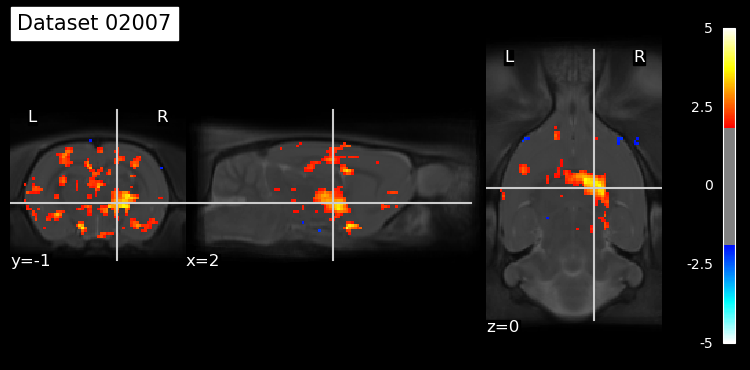

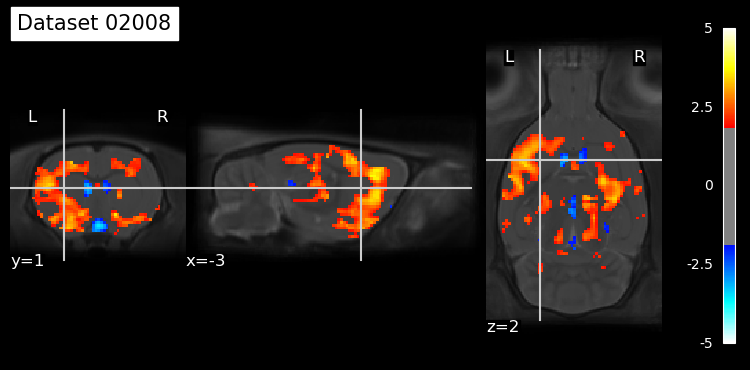

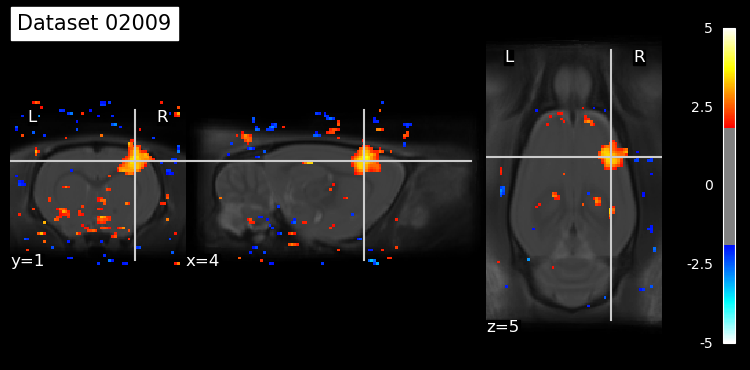

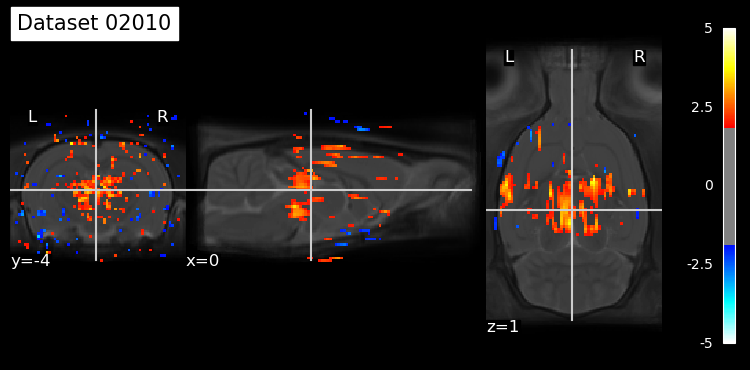

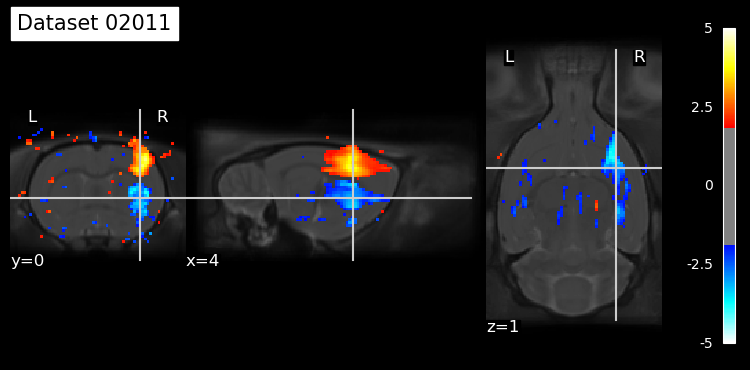

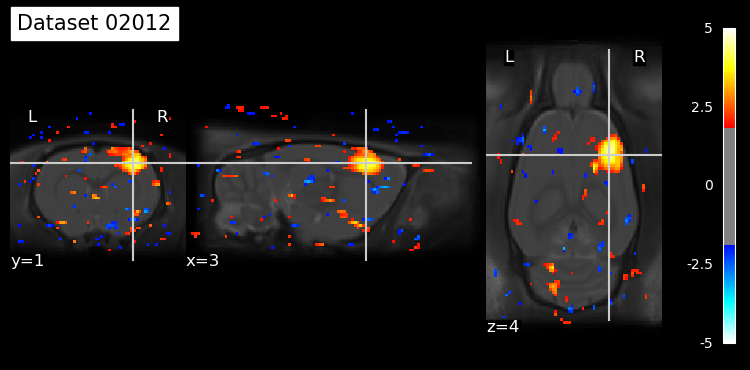

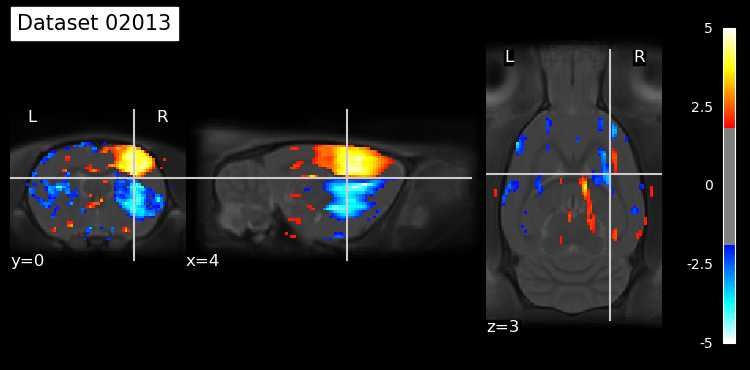

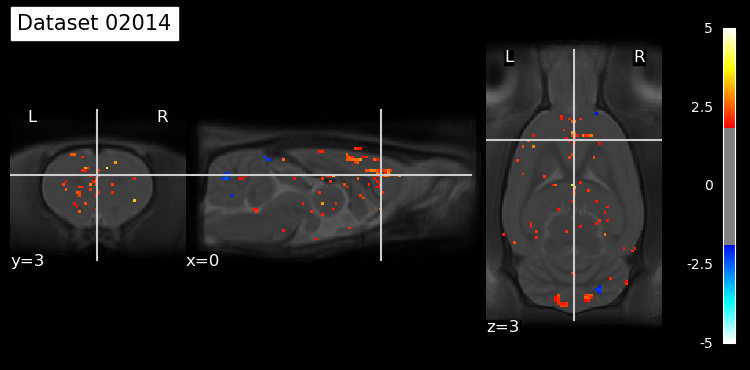

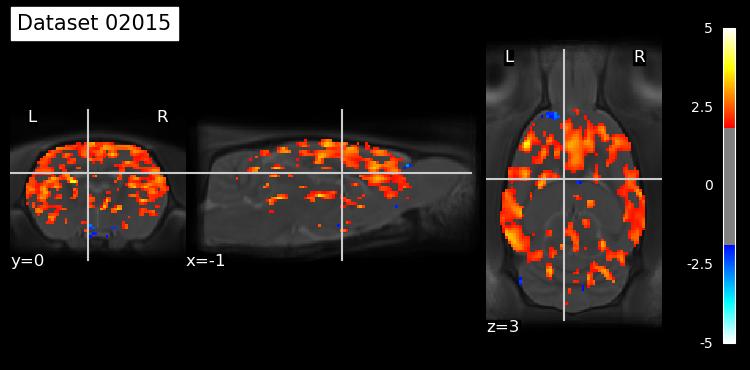

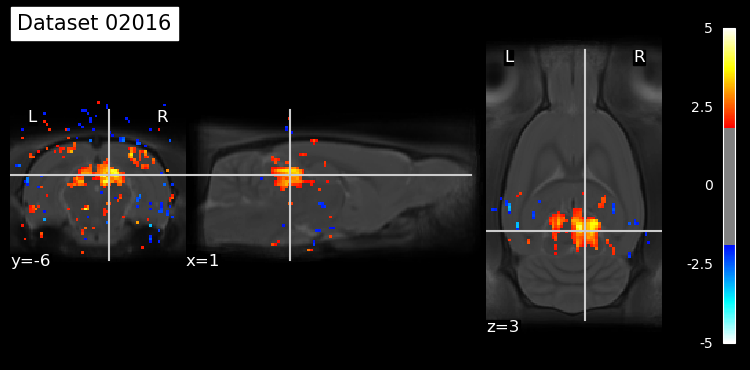

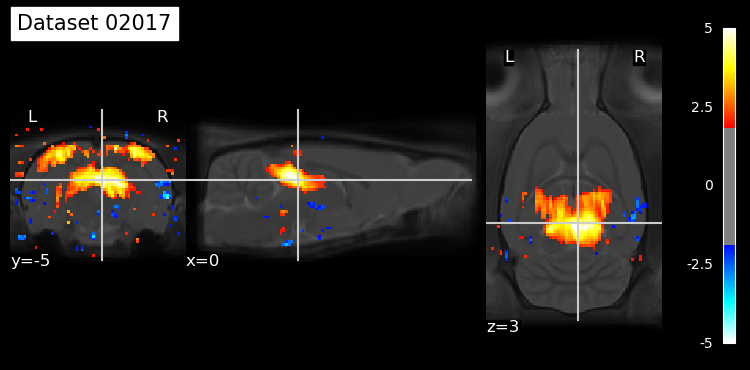

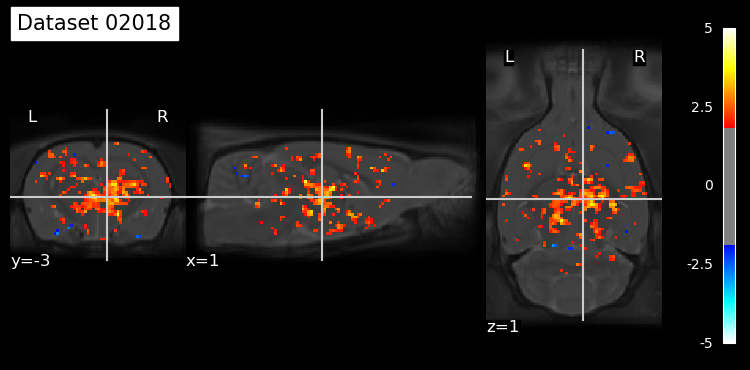

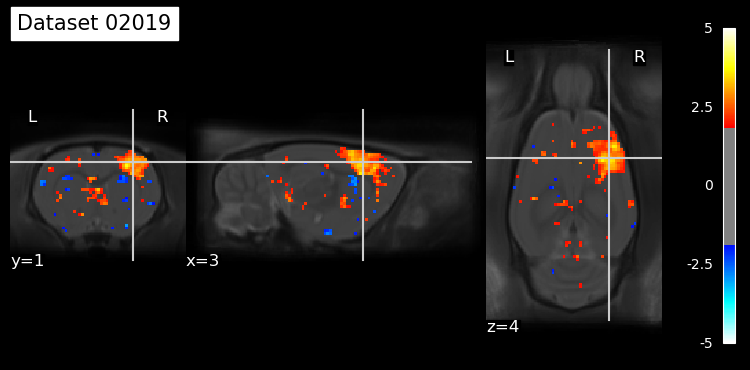

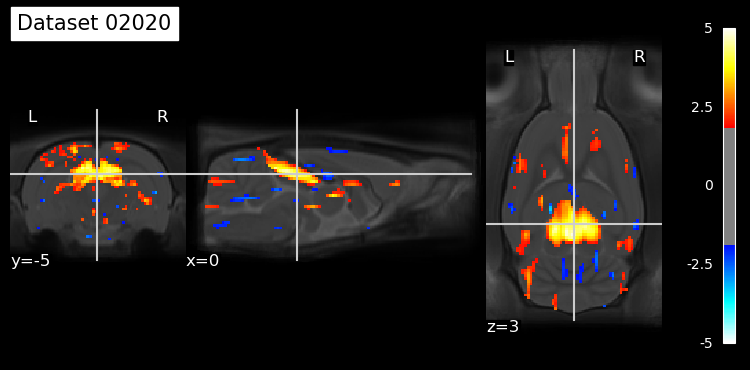

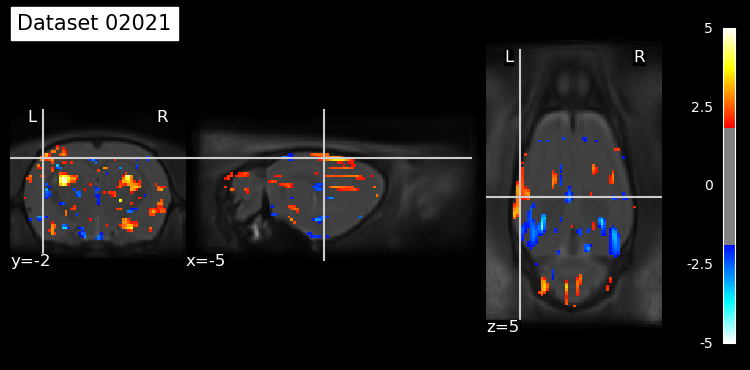

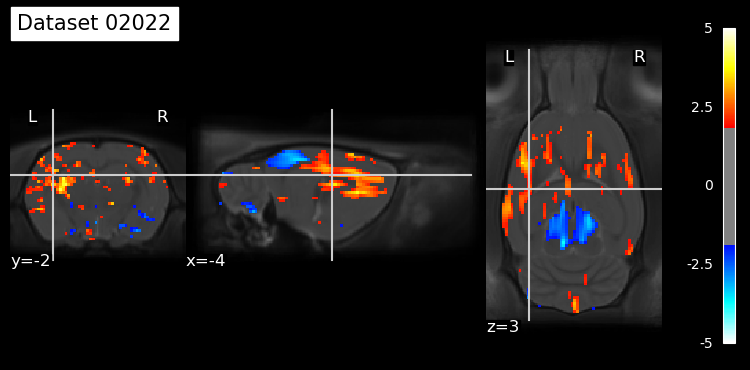

In [4]:
# ---------- SECOND LEVEL ANALYSIS ------------
# ---------------- Default HRF ----------------

print('First level analysis used:', hrf_function)

for index in range(1, 23):
    
    # --- Define variables ---
    df['rat.sub'] = df['rat.sub'].astype(str)
    line = df[df['rat.sub'] == str(2000 + index) + "00"].index
    ses = df.loc[line[0], 'rat.ses']
    ID = "0"+str(2000+index)
    print("ses", ses)
    print("ID:", ID)
 
    # --- Load data ---
    if hrf_function == 'glover': 
        dataset = glob.glob(analysis_folder+f'glover/beta_estimates/beta_sub-{ID}??_ses-*.nii.gz') 
    elif hrf_function == 'block':
        dataset = glob.glob(analysis_folder+f'block/beta_estimates/beta_sub-{ID}??_ses-*.nii.gz')
    else:
        print('No file to be saved. Check that hrf_function is well defined.')
    
    n_subject = len(dataset)                                                           
    print("number of subjects:", n_subject)

    second_level_input = dataset
    
    # --- Design matrix and second-level model ---
    design_matrix = pd.DataFrame([1] * len(second_level_input), 
                                columns=["intercept"])
 
    second_level_model = SecondLevelModel(smoothing_fwhm=0.1,
                                          minimize_memory=False)        #if want to get residuals?

    second_level_model = second_level_model.fit(second_level_input,
                                                design_matrix=design_matrix)


    # --- Estimate the contrast --- 
    second_stat_map = second_level_model.compute_contrast(second_level_contrast='intercept', output_type='all') 

    p_val = 0.05
    plot_stat = plotting.plot_stat_map(second_stat_map['z_score'],
                                        bg_img = template_path,
                                        threshold = 1.9,              #threshold p=p_val=0.05 uncorrected -> reduces false negative levels
                                        #cut_coords= (4 ,2, 5),        
                                        display_mode='ortho',
                                        draw_cross=True,
                                        colorbar=True,
                                        vmax = 5, 
                                        title=f"Dataset {ID}")
    
    # --- Save outputs ---  
    plt.savefig(image_dir+f'stat_map_dataset-{ID}_z_score.png')
    nib.save(second_stat_map['z_score'], z_score_dir+f'z_score_dataset-{ID}.nii.gz')         
    nib.save(second_stat_map['effect_size'], beta_dir+f'beta_dataset-{ID}.nii.gz')            
    #nib.save(second_stat_map['p_value'], p_value_dir+'p_value_dataset-{}.nii.gz'.format(ID))   
        